<a href="https://colab.research.google.com/github/luksri/ML_practice/blob/AgenticAI/multiple_agents_lang_chainandgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install langchain langgraph cassio
!pip install langchain_community
!pip install -U tiktoken langchain-groq langchainhub langchain langgraph langchain_huggingface

In [14]:
import cassio
ASTRA_DB_APPLICATION_TOKEN="AstraCS:MsWKDxHtQNqAvPtsILDwSESe:91d48e25f5afff2799a9778fecc8a13e4d42c4ece6cdd7a3c4c7b344efd34afc"
ASTRA_DB_ID = "de80c0e4-519e-4bff-a230-52a126bc8313"
cassio.init(token=ASTRA_DB_APPLICATION_TOKEN, database_id=ASTRA_DB_ID)

In [15]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

### load the urls
docs = [WebBaseLoader(url).load() for url in urls]
doc_list = [item for sublist in docs for item in sublist]
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500, chunk_overlap=0)
docs_split = text_splitter.split_documents(doc_list)

In [16]:
### convert the text to embeddings
from langchain_huggingface import HuggingFaceEmbeddings
embeddings =  HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [17]:
from langchain.vectorstores import Cassandra

astral_vector_store = Cassandra(embedding=embeddings,
                                table_name='qa_mini_demo',
                                session=None,
                                keyspace=None)

In [18]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
astral_vector_store.add_documents(docs_split)
print("inserted %i headlines"%len(docs_split))
astral_vector_index = VectorStoreIndexWrapper(vectorstore=astral_vector_store)

inserted 88 headlines


In [19]:
retriever = astral_vector_store.as_retriever()
# retriever.invoke("what is agent")

In [20]:
### create langgraph application that can create a router for the multiple agents
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

In [21]:
## Data Model : that is used to search between wikisearch and astral db
class RouteQuery(BaseModel):
  """ Router a user query to the most relevant datasource"""

  datasource: Literal["vectorstore","wiki_search"] = Field(
      ...,
      description="Given a user question choose to route it to wiki or vectorstore"
  )

In [22]:

from google.colab import userdata
# LLM with function call
from langchain_groq import ChatGroq
import os
groq_api_key=userdata.get('GROQ_API_KEY')
os.environ["GROQ_API_KEY"]=groq_api_key


llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")

## apply the model that we created earlier
structured_llm_router = llm.with_structured_output(RouteQuery)

In [23]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7ca1c049c850>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7ca1c049d360>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [24]:

# Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "who is Sharukh Khan?"}
    )
)

datasource='wiki_search'


In [25]:

print(question_router.invoke({"question": "What are the types of agent memory?"}))

datasource='vectorstore'


In [26]:
!pip install langchain_community
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=38ac708dd7256de48f507824ec1a3e6cba1491cd5863ef4a59b1034b5a97136c
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [27]:
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=200)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper)

In [28]:
wiki.run("tell me about sharukh khan")

'Page: Shah Rukh Khan\nSummary: Shah Rukh Khan (pronounced [ˈʃɑːɦɾʊx xɑːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Refe'

In [29]:
### create Ai agent application using lang graph


In [30]:
## Graph

from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [31]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [32]:
def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    print("---HELLO--")
    question = state["question"]
    print(question)

    # Wiki search
    docs = wiki.invoke({"query": question})
    #print(docs["summary"])
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}

In [33]:
### Edges ###


def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [34]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)
# Define the nodes
workflow.add_node("wiki_search", wiki_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge( "retrieve", END)
workflow.add_edge( "wiki_search", END)
# Compile
app = workflow.compile()

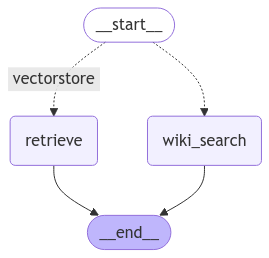

In [35]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [36]:
from pprint import pprint

# Run
inputs = {
    "question": "What is agent?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'][0].dict()['metadata']['description'])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---


"Node 'retrieve':"
'\n---\n'
('Building agents with LLM (large language model) as its core controller is a '
 'cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer '
 'and BabyAGI, serve as inspiring examples. The potentiality of LLM extends '
 'beyond generating well-written copies, stories, essays and programs; it can '
 'be framed as a powerful general problem solver.\n'
 'Agent System Overview\n'
 'In a LLM-powered autonomous agent system, LLM functions as the agent’s '
 'brain, complemented by several key components:\n'
 '\n'
 'Planning\n'
 '\n'
 'Subgoal and decomposition: The agent breaks down large tasks into smaller, '
 'manageable subgoals, enabling efficient handling of complex tasks.\n'
 'Reflection and refinement: The agent can do self-criticism and '
 'self-reflection over past actions, learn from mistakes and refine them for '
 'future steps, thereby improving the quality of final results.\n'
 '\n'
 '\n'
 'Memory\n'
 '\n'
 'Short-term memory: I wo

<ipython-input-36-a4ba987db3a3>:16: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  pprint(value['documents'][0].dict()['metadata']['description'])


In [39]:
from pprint import pprint

# Run
inputs = {
    "question": "who are Avengers"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

---ROUTE QUESTION---
---ROUTE QUESTION TO Wiki SEARCH---
---wikipedia---
---HELLO--
who are Avengers
"Node 'wiki_search':"
'\n---\n'
Document(metadata={}, page_content='Page: Young Avengers\nSummary: The Young Avengers are the names of two superhero teams appearing in American comic books published by Marvel Comics. Created by Allan Heinberg and Jim Cheung, the first ')
